# Case study of uniaxial tensile tests

This is an example of how to use ParaMaterial to process a dataset of uniaxial tensile test measurements.



## Data preparation
- **Make the info table.** This should be a .csv or .xlsx file where the columns are metadata categories. The first column must contain the *test id* --- a unique string that links the information about the test in that row to the measurements data in a separate file.
- **Format the data files.** The time-series measurements for each test should be saved in a file named "*\<test id\>*.csv".
- **Exploratory data analysis.** Quick investigation and categorisation of subsets. Visualisation of data.

Import libraries.

In [1]:
import os
from pathlib import Path

import pandas as pd
import seaborn as sns

import paramaterial as pam
from paramaterial.plug import DataSet

Configure input/output paths.

In [2]:
data_in = Path('data/01 raw data')
info_in = None
data_out = Path('data/01 prepared data')
info_out = Path('info/01 prepared info.xlsx')

### Make the info table
In this example, some of the information for each test is stored in the filenames of the .csv files and some of the information needs to be extracted from the paper.

Extract info from the filenames and make the info table.

| Abbreviation | Test type                 |
|--------------|---------------------------|
| UT           | Uniaxial tension test     |
| PST          | Plane-strain tension test |


In [3]:
info_lists = [[filename] + filename.split('_')[:4] for filename in os.listdir(data_in)]
info_table = pd.DataFrame(info_lists, columns=['old filename', 'test type', 'temperature', 'lot', 'number'])
info_table

,old filename,test type,temperature,lot,number
0,P_020_F_1_017_198_18.csv,P,020,F,1
1,P_020_F_2_018_202_19.csv,P,020,F,2
2,P_020_F_3_019_208_25.csv,P,020,F,3
3,P_020_G_1_021_197_16.csv,P,020,G,1
4,P_020_G_2_022_195_24.csv,P,020,G,2
...,...,...,...,...,...
149,T_300_E_3_170_094_18.csv,T,300,E,3
150,T_300_F_1_171_133_31.csv,T,300,F,1
151,T_300_G_1_175_129_32.csv,T,300,G,1
152,T_300_H_1_179_128_31.csv,T,300,H,1


Add a unique test ID column.

In [4]:
info_table['test id'] = [f'test_ID_{i + 1:03d}' for i in range(len(info_table))]
info_table = info_table.set_index('test id').reset_index()  # move the test id column to the far left
info_table

,test id,old filename,test type,temperature,lot,number
0,test_ID_001,P_020_F_1_017_198_18.csv,P,020,F,1
1,test_ID_002,P_020_F_2_018_202_19.csv,P,020,F,2
2,test_ID_003,P_020_F_3_019_208_25.csv,P,020,F,3
3,test_ID_004,P_020_G_1_021_197_16.csv,P,020,G,1
4,test_ID_005,P_020_G_2_022_195_24.csv,P,020,G,2
...,...,...,...,...,...,...
149,test_ID_150,T_300_E_3_170_094_18.csv,T,300,E,3
150,test_ID_151,T_300_F_1_171_133_31.csv,T,300,F,1
151,test_ID_152,T_300_G_1_175_129_32.csv,T,300,G,1
152,test_ID_153,T_300_H_1_179_128_31.csv,T,300,H,1


Add the information from the paper (just the 'rate', here), and convert the temperatures to floats.

Also update the test type abbreviations.

| Abbreviation | Test type                 |
|--------------|---------------------------|
| UT           | Uniaxial tension test     |
| PST          | Plane-strain tension test |


In [5]:
info_table['rate'] = 8.66e-4  # units (/s) and all tests performed at same rate
info_table['temperature'] = pd.to_numeric(info_table['temperature'])  # units (C)
info_table['test type'] = info_table['test type'].replace('T', 'UT')
info_table['test type'] = info_table['test type'].replace('P', 'PST')

info_table

,test id,old filename,test type,temperature,lot,number,rate
0,test_ID_001,P_020_F_1_017_198_18.csv,PST,20,F,1,0.000866
1,test_ID_002,P_020_F_2_018_202_19.csv,PST,20,F,2,0.000866
2,test_ID_003,P_020_F_3_019_208_25.csv,PST,20,F,3,0.000866
3,test_ID_004,P_020_G_1_021_197_16.csv,PST,20,G,1,0.000866
4,test_ID_005,P_020_G_2_022_195_24.csv,PST,20,G,2,0.000866
...,...,...,...,...,...,...,...
149,test_ID_150,T_300_E_3_170_094_18.csv,UT,300,E,3,0.000866
150,test_ID_151,T_300_F_1_171_133_31.csv,UT,300,F,1,0.000866
151,test_ID_152,T_300_G_1_175_129_32.csv,UT,300,G,1,0.000866
152,test_ID_153,T_300_H_1_179_128_31.csv,UT,300,H,1,0.000866


### Format the data files.
In this example, the files are already in .csv format. We just check that the column headers are the same and that there are no duplicates, then rename the files by test id.

Check column headers.

In [6]:
pam.preparing.check_column_headers('data/01 raw data')

Checking column headers...
First file headers:
	['Strain', 'Stress_MPa']
Headers in all files are the same as in the first file.


Check uniqueness.

In [7]:
pam.preparing.check_for_duplicate_files('data/01 raw data')

No duplicate files found in "data/01 raw data".


Write the prepared data and rename the files by test id. Also write the prepared info table.

In [8]:
pam.preparing.copy_data_and_rename_by_test_id(data_in, data_out, info_table)
info_table.to_excel(info_out)

Copied 154 files in data\01 raw data to data\01 prepared data.


### Exploring the raw data
We want to identify useful groupings and make visualisations.

In [9]:
info_table.nunique().sort_values()

rate              1
test type         2
number            3
temperature       6
lot               9
test id         154
old filename    154
dtype: int64

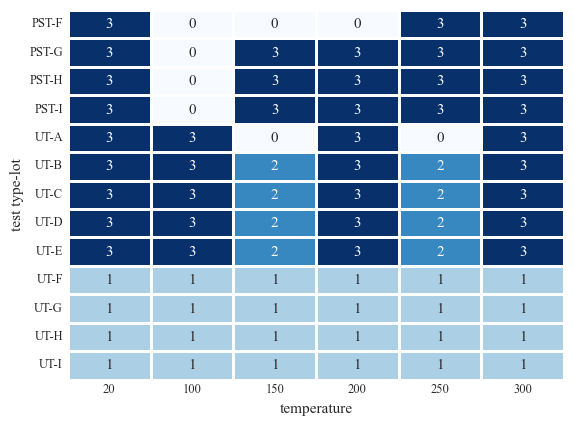

In [10]:
exp_matrix = pam.preparing.make_experimental_matrix(info_table, index=['test type', 'lot'], columns='temperature')
sns.heatmap(exp_matrix, linewidths=1, cbar=False, annot=True, cmap='Blues');

### Visualise the prepared data.

In [11]:
prepared_set = DataSet(data_out, info_out).sort_by(['temperature', 'lot'])

#### Observe lot variation

Colour by lot to observe variation within and between lots.

In [12]:
lot_styler = pam.plotting.Styler(
    color_by='lot', color_by_label='Lot', cmap='tab10',
    linestyle_by='test type', linestyle_by_label='Type',
    plot_kwargs={'grid': True}
).style_to(prepared_set)

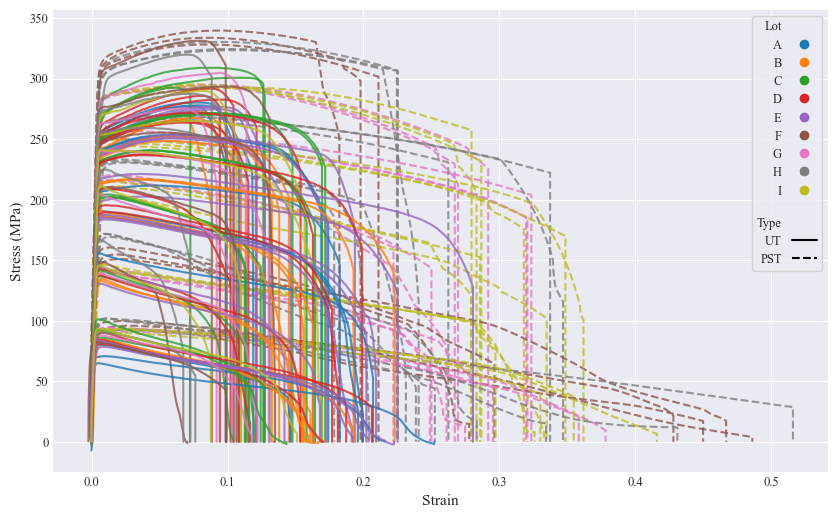

In [13]:
pam.plotting.dataset_plot(ds=prepared_set, styler=lot_styler, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)',
                          alpha=0.8);

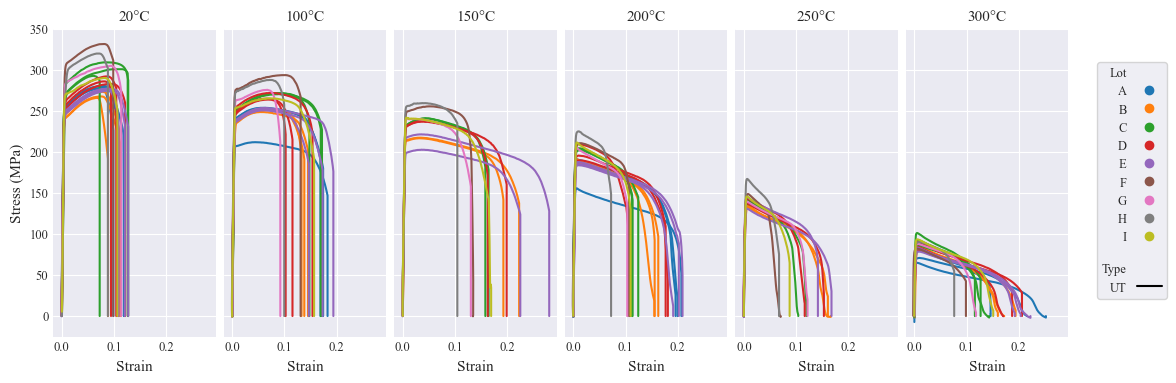

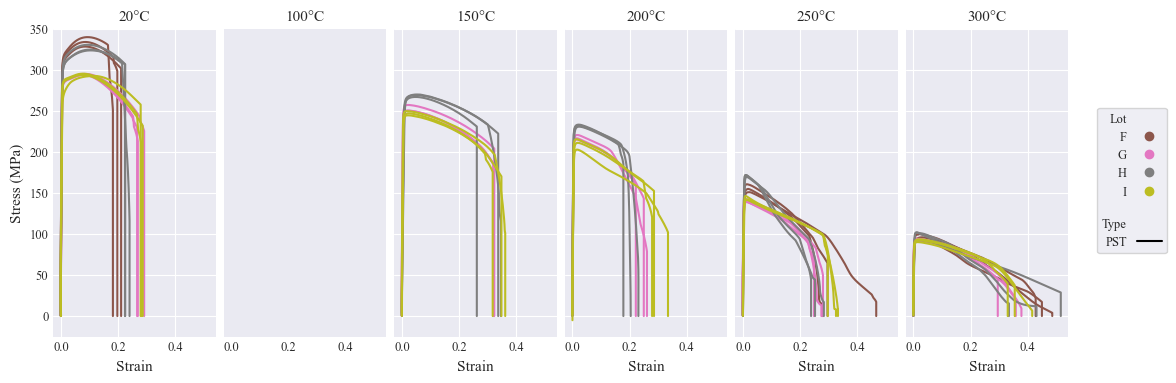

In [27]:
temperatures = sorted(prepared_set.info_table['temperature'].unique())
for test_type in ('UT', 'PST'):
    pam.plotting.dataset_subplots(
        ds=prepared_set, x='Strain', y='Stress_MPa', xlabel='Strain', ylabel='Stress (MPa)',
        styler=lot_styler.style_to(prepared_set[{'test type': test_type}]), plot_legend=False,
        figsize=(14, 4), shape=(1, 6), sharex='row', ylim=(-25., 350.),
        rows_by='test type', cols_by='temperature', row_vals=[[test_type]],
        col_vals=[[T] for T in temperatures], col_titles=[f'{T}°C' for T in temperatures]
    );

#### Observe temperature sensitivity

Colour by temperature to observe temperature sensitivity.

In [15]:
temperature_styler = pam.plotting.Styler(
    color_by='temperature', color_by_label='Temperature (°C)', cmap='plasma',
    linestyle_by='test type', linestyle_by_label='Type',
    plot_kwargs={'grid': True}
).style_to(prepared_set)

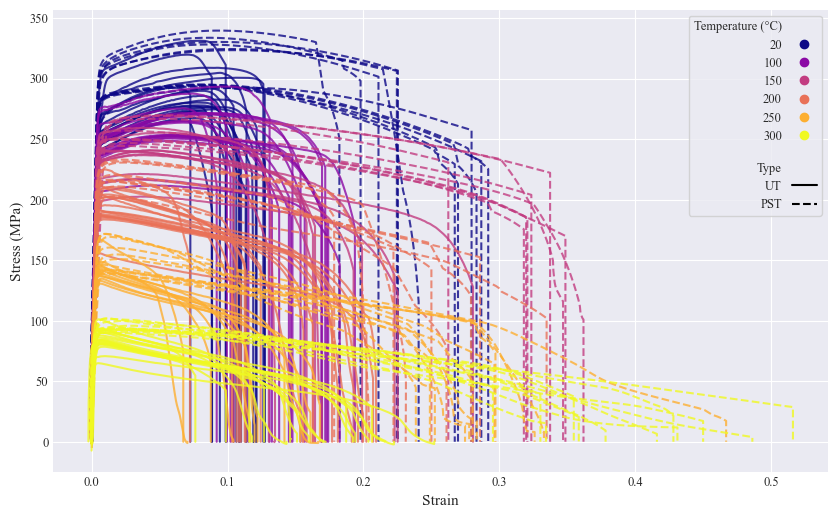

In [16]:
pam.plotting.dataset_plot(prepared_set, styler=temperature_styler, x='Strain', y='Stress_MPa', ylabel='Stress (MPa)',
                          alpha=0.8);

Observe temperature sensitivity of each lot using a subplot. Look at the uniaxial and plane-strain compression tests separately.

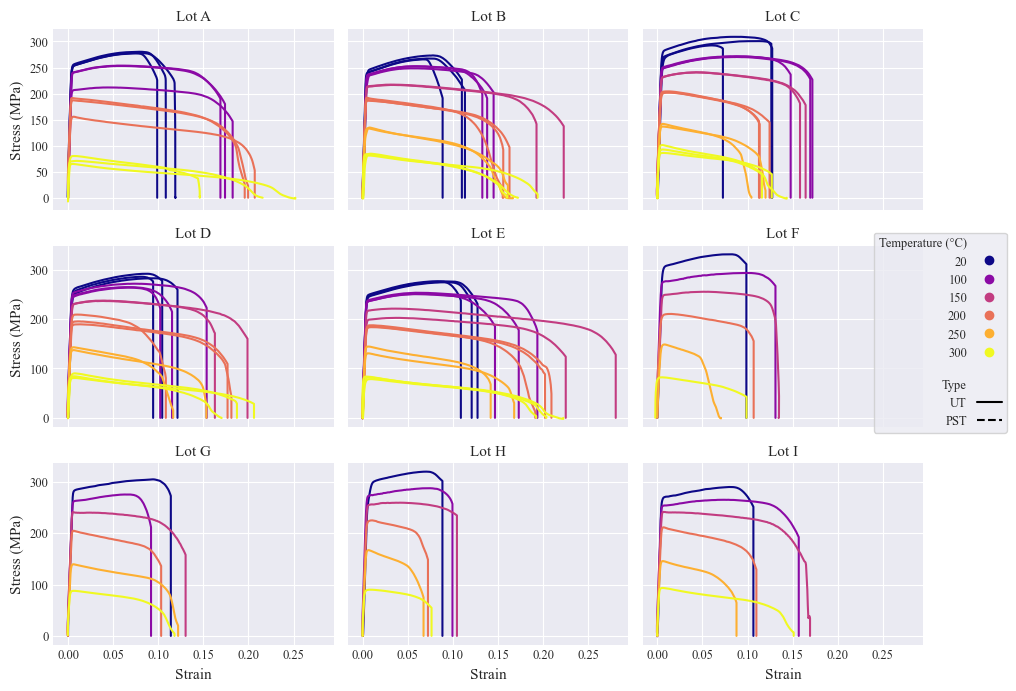

In [20]:
uniaxial_set = prepared_set[{'test type': 'UT'}]
pam.plotting.dataset_subplots(
    ds=uniaxial_set, shape=(3, 3), sharex='all',
    x='Strain', y='Stress_MPa', ylabel='Stress (MPa)',
    styler=temperature_styler, hspace=0.2, plot_legend=False,
    rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
    cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
    plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI'],
);

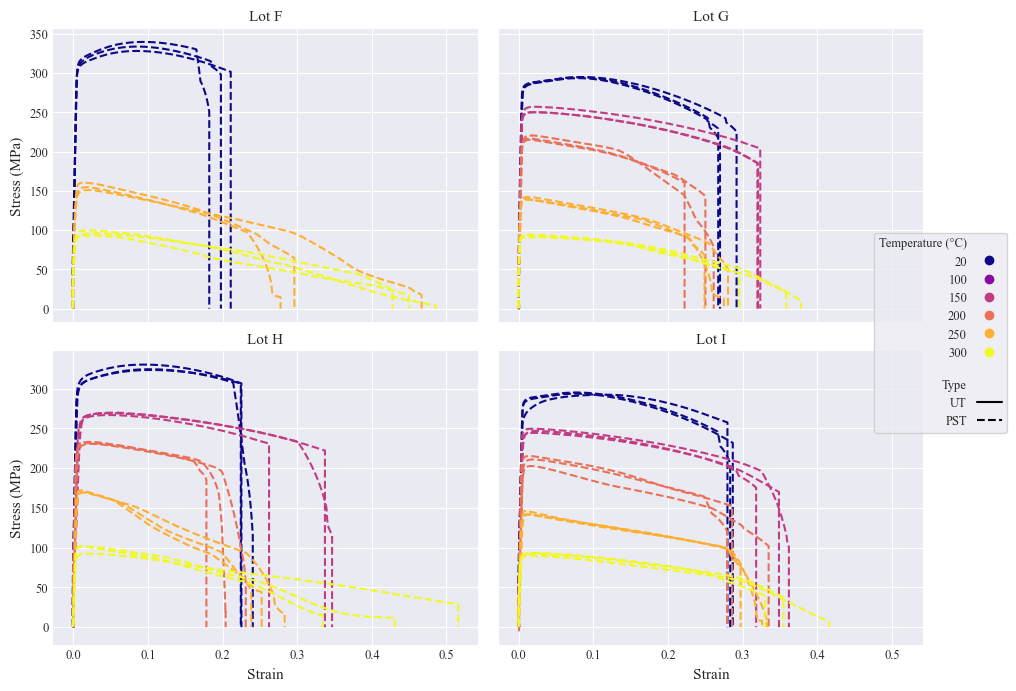

In [30]:
plane_strain_set = prepared_set[{'test type': 'PST'}]
pam.plotting.dataset_subplots(
    ds=plane_strain_set, shape=(2, 2), sharex='all',
    x='Strain', y='Stress_MPa', ylabel='Stress (MPa)',
    styler=temperature_styler, grid=True, hspace=0.1,
    rows_by='lot', row_vals=[[a] for a in 'FGHI'],
    cols_by='lot', col_vals=[[a] for a in 'FGHI'],
    plot_titles=[f'Lot {a}' for a in 'FGHI'],
    plot_legend=False, legend=False
);